# Einbinden der Bibliotheken

In [5]:
# Imports
import os
import json

from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter
import numpy as np
from matplotlib import pyplot as plt

# Configure plot size
plt.rcParams["figure.figsize"] = (10,5)

# Laden der Datei
Während der Messung werden die empfangenen Daten in Listen gespeichert. Diese werden nach Beendung der Messung als JSON-Datei gespeichert.
Um das aufgezeichnete Signal auszuwerten, wird dieses zunächst geladen.
Die einzelnen Messwerte und die dazugehörenden Zeitwerte werden in zwei Listen (x, y) gespeichert.

In [6]:
DIRECTORY = '../records'

def get_signal(filename):
    with open(os.path.join(DIRECTORY, filename)) as file:
        return json.load(file)
    
signal = get_signal('20180429-212736_Maria_gd_.json')
x = signal['times']
y = signal['channels'][0]

# Verarbeitung der Rohdaten
Das empfangene, ungefilterte Signal ist zunächst unbrauchbar. Es beinhaltet sehr viele Störfrequenzen. 

## Resampling
Wie man beispielhaft aus der Zeitdifferenz der ersten 10 Messwerte erkennen kann, ist die Abtastrate nicht konstant.

In [7]:
[x[i+1] - x[i] for i in range(10)]

[0.0005740560009144247,
 1.1071002518292516e-05,
 0.000546176997886505,
 1.0957999620586634e-05,
 0.0007707860058872029,
 1.3389995729085058e-05,
 0.04689133800275158,
 1.89829952432774e-05,
 0.0006394459996954538,
 1.233000512002036e-05]

Die Inkonstanz wird in erster Linie durch das Buffering und somit inkonstanten Verzögerungen bei der Übertragung oder durch Paketverluste bei der Übertragung verursacht. Die meisten Algorithmen zur Signalverarbeitung, wie beispielsweise Passfilter, benötigen jedoch ein Signal mit konstanter Abtastrate. Das Signal wird deshalb zunächst auf eine fixe Abtastrate von 100 Hz resampled.

In [8]:
def resample(x, y, frequency):
    # Calculate the new sample amount and the period length of one sample
    length = x[-1]
    samples_amount = int(length * frequency)
    period_length = 1 / frequency
    # Create list with x-values (time values) for the given frequency
    # First value has to be greater or equal the first value of the input
    x_new = [period_length * i for i in range(samples_amount) if period_length * i >= x[0]]
    
    # Calculate interpolated y values
    y_new = [interp1d(x, y)(i).tolist() for i in x_new]

    return x_new, y_new

FREQUENCY = 100 # Hz
x, y = resample(x, y, FREQUENCY)

## Filterung
### Schnelle Fourier-Transformation
Aus dem Graphen der Fourier-Transformation kann man erkennen, dass das Signal ein breites Spektrum an Frequenzen enthält.

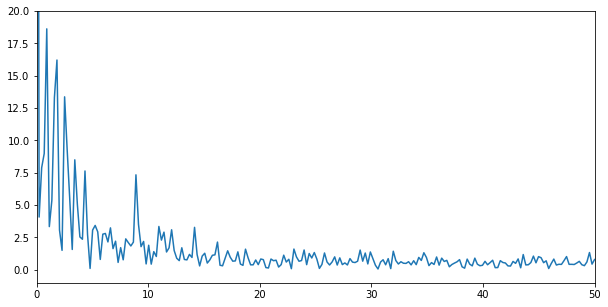

In [9]:
def fft(y, frequency):
    # Get real amplitudes of FFT (only in positive frequencies)
    fft_values = np.absolute(np.fft.rfft(y))

    # Get frequencies for amplitudes in Hz
    dt = 1 / frequency
    fft_freq = np.fft.rfftfreq(len(y), dt)

    return fft_freq, fft_values

# Plot Graph
plt.plot(*fft(y, FREQUENCY))
plt.xlim(0,50)
plt.ylim(-1, 20)
plt.show()

### Bandpass-Filter
Man kann deutlich erkennen, dass sich die größte Leistung im Bereich unter 20 Hz befindet. Gerade im hochfrequenten Bereich finden sich viele Störsignale. Diese stammen hauptsächlich von drei Quellen: erstens von körpereigenen Stromflüssen, welche nicht für die Messung relevant sind; zweitens von externen Interferenzen (z.B.: Wechselstrom: 50 Hz) und drittens werden sie einfach durch eine praktisch unmögliche 100% exakte Messung hervorgerufen. Um ein sauberes Signal zu erhalten werden diese Frequenzen mittels eines Hochpass-Filters entfernd. Die richtige Wahl der Grenzfrequenz ist dabei kritisch. Einerseits sollte sie niedrig gehalten werden, um einen möglichst großen Bereich von Störfrequenzen zu entfernen. Andererseits darf sie auch nicht zu klein sein, da dadurch das Signal verfälscht wird. Da bei dieser Messung die Testperson deutlich und nicht besonders schnell blinzelte, kann eine relativ kleine Grenzfrequenz von 5 Hz für den Hochpassfilter verwendet werden.
Zusätzlich kann ein Tiefpass-Filter verwendet werden, welcher tiefe Frequnzen unterhalb einer bestimmten Grenzfrequenz entfernd. Somit wird das Signal unterschiedlich stark zu 0 V hingezogen. Bei der Elektrookulografie ist dies grundsätzlich nicht sinnvoll. Der eigentliche Messwert, aus dem man den Blickrichtungswinkel ableiten kann, wird dadurch verfälscht. Bei der Detektierung des Blinzelns hingegend ist nicht der exakte Wert der gemessenen Spannung zu einem bestimmten Zeitpunk ausschlaggebend, sondern die Änderung der Spannung innerhalb eines bestimmten Frequenzbereichs. Deshalb ist ein Tiefpassfilter sinvoll, da dadurch die Peaks deutlicher erkennbar sind. Hier wird eine Grenzfrequenz von 2 Hz für den Tiefpass-Filter verwendet. In Summe bedeutet dies, dass nur der Frequenzbereich zwischen 2 und 5 Hz betrachtet wird.

In [10]:
def butter_bandpass_filter(data, lowcut, highcut, frequency, order=1):
    nyq = 0.5 * frequency
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

LOWCUT = 2
HIGHCUT = 5
y_filtered = butter_bandpass_filter(y, LOWCUT, HIGHCUT, FREQUENCY)

Im folgendem Diagramm kann man die Graphen des ungefilterten Signals <font color='red'>(rot)</font> und des gefilterten <font color='blue'>(blau)</font> vergleichen. Man kann ausserdem Beobachten, welche Auswirkung die Veränderung der Grenzfrequenzen des Tief- und Hochpass-Filters auf das Signal hat.

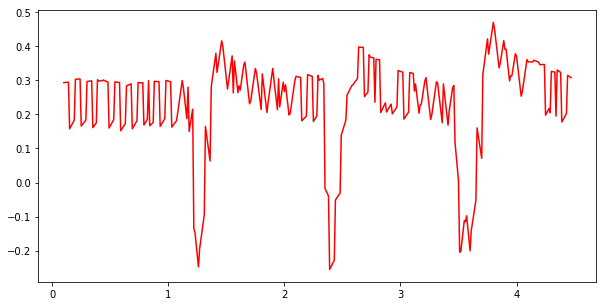

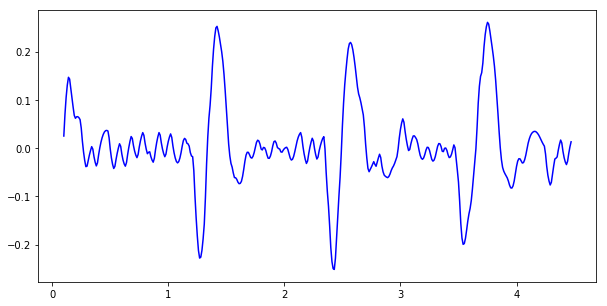

In [11]:
plt.plot(x, y, color='red')
plt.show()
plt.plot(x, y_filtered, color='blue')
plt.show()

# Blinzel Detektierung
Das Blinzeln ist als relativ starker Peak im Signal erkennbar. Das Ziel ist es nun diese Peaks zu detektieren. Zunächst werden alle lokalen Maxima bestimmt. Dann wird ein Schwellwert definiert, ab welchen ein Peak als Blinzeln gezählt wird. Die Größe der gemessenen Spannung und somit auch das Ausmaß des Ausschlages der Peaks variert von Messung zu Messung sehr stark. Dies kann von der momentanen Hautleitfähigkeit, aber auch durch das leicht unterschiedliche Aufbringen der Sensoren beinflusst werden. Aus diesem Grunde ist es nicht sinnvoll einen fixen, konkreten Schwellwert zu definieren, sondern ihn bei jeder Session dynamisch zu berechnen. Hier wird als Schwellwert einfach der größte gemessene Wert multipliziert mit 0.75 verwendet. Dabei werden zwei Bedingungen vorausgesetzt. Erstens muss im betrachtetem Intervall mindestens ein Peak eines Blinzelns vorhanden sein. Ansonst würde ein viel zu geringer Schwellwert berechnet werden und es würden bereits kleinere Peaks fälschlicherweise als Blinzeln interpretiert werden. Zweitens muss das Signal beim nicht Blinzeln um die 0 V sein und der Ausschlag muss mindestens positiv sein. Dies kann durch Verwendung eines Tiefpass-Filters garantiert werden.

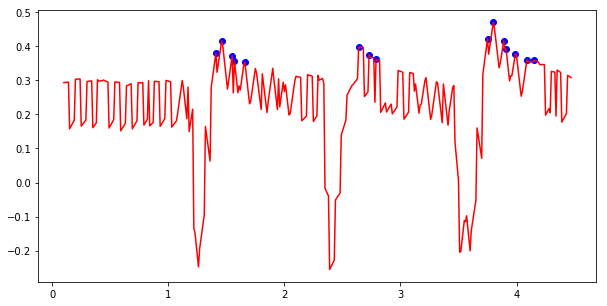

Detected blinks: 15


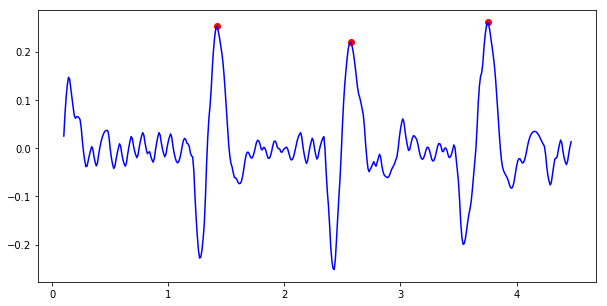

Detected blinks: 3


In [12]:
def detect_peaks(y):
    """Get indices all peaks"""
    # Peak: value has to be greater than previous and following value
    peaks = [i for i in range(1, len(y) - 1) if y[i] > y[i-1] and y[i] > y[i+1]]
    
    # Get minimum peak height
    mph = max(y) * 0.75 # Minimum peak hight
    
    # Get peaks greater than minimum-peak-height
    peaks = [peak for peak in peaks if y[peak] >= mph]
    return peaks

# Plot unfiltered Signal with peaks
peaks_indexes = detect_peaks(y)
for peak_index in peaks_indexes:
    plt.plot(x[peak_index], y[peak_index], 'bo')

plt.plot(x, y, color='red')
plt.show()
print('Detected blinks: ' + str((len(peaks_indexes))))

# Plot filtered Signal with peaks
peaks_indexes = detect_peaks(y_filtered)
for peak_index in peaks_indexes:
    plt.plot(x[peak_index], y_filtered[peak_index], 'ro')

plt.plot(x, y_filtered, color='blue')
plt.show()
print('Detected blinks: ' + str((len(peaks_indexes))))

Aus den Ergebnisen kann man erkennen, dass im ersten Fall, bei Analysierung des ungefilterten Siganls, die Detektierung nicht funktioniert hat. Es wurden viele lokale Maxima (15) fälschlicherweise als Blinzeln gewertet. Dies ist auf die Nichterfüllung der zweiten Bedingung zurückzuführen. Beim Nichtblinzeln beträgt das Signal zwischen 0.2 und 0.3 μV und nicht wie vorausgesetzt um die 0 V. Außerdem schlägt das Signal beim Blinzeln nur negativ aus. Deshalb wurden trotz der vielen false-positive Detektierungen die eigentlichen Blizel-Peaks nicht erkannt.
Im zweiten Fall, bei der Analysierung des gefilterten Signals, wurden das dreifache Blinzeln der Testperson richtig erkannt!